In [20]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(
    action="ignore", category=FutureWarning
)  # Deprecation warnings for later version of sklearn

In [21]:
r_df = pd.read_csv("data/Reddit_Data.csv")
t_df = pd.read_csv("data/Twitter_Data.csv")
test_df = pd.read_csv("data/sentimentdataset.csv")

In [22]:
r_df.columns = ["Text", "Label"]
t_df.columns = ["Text", "Label"]

r_df = r_df.dropna()
t_df = t_df.dropna()

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")


def get_sentiment_label(word):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(word)
    compound_score = sentiment_scores["compound"]
    if compound_score >= 0.05:
        return 1  # Positive
    elif compound_score <= -0.05:
        return -1  # Negative
    else:
        return 0  # Neutral


test_df["Label"] = test_df["Sentiment"].apply(get_sentiment_label)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michaelnguy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
df = pd.concat([r_df, t_df])
df["Text"] = df["Text"].astype(str)

test_df["Text"] = test_df["Text"].astype(str)

Text Preprocessing


In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import emoji
import re
import contractions
from collections import OrderedDict

# Download NLTK data
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("stopwords")

# Initialize the necessary tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))


def expand_contractions(text):
    return contractions.fix(text)


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)

    # Convert emojis to text
    text = emoji.demojize(text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r"@\w+|#\w+", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Lemmatize and stem each token
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token is not None]
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Remove duplicate tokens while preserving order
    tokens = list(OrderedDict.fromkeys(tokens))

    # Remove extra whitespace
    text = " ".join(tokens)
    text = re.sub(r"\s+", " ", text).strip()

    return text


# Preprocess the comments
df["Preproc"] = df["Text"].apply(preprocess_text)
test_df["Preproc"] = test_df["Text"].apply(preprocess_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelnguy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/michaelnguy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelnguy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelnguy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Logistic Regression


In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df["Preproc"], df["Label"], test_size=0.2, random_state=42
)
X_test = test_df["Preproc"]
y_test = test_df["Label"]

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Define parameter grids for the vectorizer
vectorizer_param_grid = {
    "max_df": [0.75, 1.0],
    "min_df": [1, 2],
    "ngram_range": [(1, 1), (1, 2)],
    "max_features": [5000],
}

# Define parameter grid for the classifier
classifier_param_grid = {
    "C": [0.1, 1, 10, 20, 50, 100],
    "solver": ["lbfgs", "liblinear"],
    "multi_class": ["ovr", "multinomial"],
}

best_score = 0
best_params = {}

# Iterate over vectorizer parameter sets
for max_df in vectorizer_param_grid["max_df"]:
    for min_df in vectorizer_param_grid["min_df"]:
        for ngram_range in vectorizer_param_grid["ngram_range"]:
            for max_features in vectorizer_param_grid["max_features"]:
                # Fit the vectorizer on the training set
                vectorizer = TfidfVectorizer(
                    max_df=max_df,
                    min_df=min_df,
                    ngram_range=ngram_range,
                    max_features=max_features,
                )
                X_train_transformed = vectorizer.fit_transform(X_train)
                X_val_transformed = vectorizer.transform(X_val)

                # Iterate over classifier parameter
                for C in classifier_param_grid["C"]:
                    for solver in classifier_param_grid["solver"]:
                        for multi_class in classifier_param_grid["multi_class"]:
                            # Skip incompatible combinations
                            if solver == "liblinear" and multi_class == "multinomial":
                                continue
                            # Train the classifier on the training set
                            classifier = LogisticRegression(
                                C=C,
                                solver=solver,
                                multi_class=multi_class,
                                max_iter=10000,
                            )
                            try:
                                classifier.fit(X_train_transformed, y_train)

                                # Evaluate the classifier on the validation set
                                y_val_pred = classifier.predict(X_val_transformed)
                                score = accuracy_score(y_val, y_val_pred)

                                # Check if this is the best model so far
                                if score > best_score:
                                    best_score = score
                                    best_params = {
                                        "vectorizer": {
                                            "max_df": max_df,
                                            "min_df": min_df,
                                            "ngram_range": ngram_range,
                                            "max_features": max_features,
                                        },
                                        "classifier": {
                                            "C": C,
                                            "solver": solver,
                                            "multi_class": multi_class,
                                        },
                                    }
                                print(
                                    "done with",
                                    max_df,
                                    min_df,
                                    ngram_range,
                                    max_features,
                                    C,
                                    solver,
                                    multi_class,
                                )
                            except Exception as e:
                                print(f"Skipping combination due to error: {e}")

# Fit the vectorizer and classifier on the combined training+validation set using the best parameters
best_vectorizer_params = best_params["vectorizer"]
vectorizer = TfidfVectorizer(**best_vectorizer_params)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

best_classifier_params = best_params["classifier"]
classifier = LogisticRegression(**best_classifier_params, max_iter=10000)
classifier.fit(X_train_transformed, y_train)

# Evaluate the final model on the test set
y_test_pred = classifier.predict(X_test_transformed)
print("Best Vectorizer Parameters:", best_vectorizer_params)
print("Best Classifier Parameters:", best_classifier_params)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

done with 0.75 1 (1, 1) 5000 0.1 lbfgs ovr
done with 0.75 1 (1, 1) 5000 0.1 lbfgs multinomial
done with 0.75 1 (1, 1) 5000 0.1 liblinear ovr
done with 0.75 1 (1, 1) 5000 1 lbfgs ovr
done with 0.75 1 (1, 1) 5000 1 lbfgs multinomial
done with 0.75 1 (1, 1) 5000 1 liblinear ovr
done with 0.75 1 (1, 1) 5000 10 lbfgs ovr
done with 0.75 1 (1, 1) 5000 10 lbfgs multinomial
done with 0.75 1 (1, 1) 5000 10 liblinear ovr
done with 0.75 1 (1, 1) 5000 20 lbfgs ovr
done with 0.75 1 (1, 1) 5000 20 lbfgs multinomial
done with 0.75 1 (1, 1) 5000 20 liblinear ovr
done with 0.75 1 (1, 1) 5000 50 lbfgs ovr
done with 0.75 1 (1, 1) 5000 50 lbfgs multinomial
done with 0.75 1 (1, 1) 5000 50 liblinear ovr
done with 0.75 1 (1, 1) 5000 100 lbfgs ovr
done with 0.75 1 (1, 1) 5000 100 lbfgs multinomial
done with 0.75 1 (1, 1) 5000 100 liblinear ovr
done with 0.75 1 (1, 2) 5000 0.1 lbfgs ovr
done with 0.75 1 (1, 2) 5000 0.1 lbfgs multinomial
done with 0.75 1 (1, 2) 5000 0.1 liblinear ovr
done with 0.75 1 (1, 2) 5000

Initial testing on real-world data found out that this model performs poorly on emojis - because the train sets didn't have any emojis.


In [28]:
# Test on real-world data results:

text = [
    "Hello this is great",
    "This stinks bad",
    "before and before",
    "I got the same water bottle",
    "Yo more of these! Run through all the styles pls",
    "🔥🔥🔥😍😍",
    "😍😍😍",
    "🔥",
    "Here's how to look exactly the same",
    "And that will be $150 sir",
    "😍",
    "Best model 👏🔥🔥",
    "Where do you get a water bottle like that?",
    "His eyes are the opposite of Moesha.",
    "dumbbbbb handsome 😍",
    "Wtf 👎🏼 trash 🗑️",
]

X_l = [preprocess_text(t) for t in text]
X = pd.DataFrame(X_l)
text_transformed = vectorizer.transform(X[0])
senti_pred = classifier.predict(text_transformed)

[text, senti_pred]

[['Hello this is great',
  'This stinks bad',
  'before and before',
  'I got the same water bottle',
  'Yo more of these! Run through all the styles pls',
  '🔥🔥🔥😍😍',
  '😍😍😍',
  '🔥',
  "Here's how to look exactly the same",
  'And that will be $150 sir',
  '😍',
  'Best model 👏🔥🔥',
  'Where do you get a water bottle like that?',
  'His eyes are the opposite of Moesha.',
  'dumbbbbb handsome 😍',
  'Wtf 👎🏼 trash 🗑️'],
 array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1., -1.])]

I decided to add following entries into the training sets and run model again.

https://www.kaggle.com/code/infamouscoder/emoji-sentiment-features


In [29]:
positive_emoji = [
    "👏",
    "🔥",
    "😍",
    "😊",
    "💕",
    "👍",
    "💖",
    "😊",
    "🎉",
    "💞",
    "😃",
    "😁",
    "😎",
    "😘",
    "💓",
    "😉",
    "😄",
    "😀",
    "💗",
    "😌",
    "😆",
    "😻",
    "🙋",
    "😇",
    "💝",
    "😋",
    "🤗",
    "😚",
    "😙",
    "😸",
    "😺",
    "😽",
]

negative_emoji = [
    "🗑️",
    "👎",
    "😫",
    "😨",
    "😢",
    "💀",
    "🤔",
    "😓",
    "😤",
    "😩",
    "😴",
    "💔",
    "😒",
    "😪",
    "😣",
    "😡",
    "😕",
    "😔",
    "😠",
    "😷",
    "😥",
    "😞",
    "😲",
    "😰",
    "😖",
    "😧",
    "😟",
    "😶",
    "😯",
    "🤒",
    "🤕",
    "😾",
    "💤",
]

In [30]:
preproc_pe = [preprocess_text(e) for e in positive_emoji]

X_train = pd.concat([X_train, pd.DataFrame(preproc_pe)], ignore_index=True, axis=0)
y_train = pd.concat([y_train, pd.DataFrame([1] * 32)], ignore_index=True, axis=0)

preproc_ne = [preprocess_text(e) for e in negative_emoji]

X_train = pd.concat([X_train, pd.DataFrame(preproc_ne)], ignore_index=True, axis=0)
y_train = pd.concat([y_train, pd.DataFrame([-1] * 33)], ignore_index=True, axis=0)

In [31]:
# X_train = X_train.astype(str)
X_train_transformed = vectorizer.fit_transform(X_train[0])

classifier.fit(X_train_transformed, y_train)

# Re-test on real-world data
X_l = [preprocess_text(t) for t in text]
X = pd.DataFrame(X_l)
text_transformed = vectorizer.transform(X[0])
senti_pred = classifier.predict(text_transformed)

[text, senti_pred]

/Users/michaelnguy/miniforge3/envs/playgroundenv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # only csr, csc, and coo have `data` attribute


[['Hello this is great',
  'This stinks bad',
  'before and before',
  'I got the same water bottle',
  'Yo more of these! Run through all the styles pls',
  '🔥🔥🔥😍😍',
  '😍😍😍',
  '🔥',
  "Here's how to look exactly the same",
  'And that will be $150 sir',
  '😍',
  'Best model 👏🔥🔥',
  'Where do you get a water bottle like that?',
  'His eyes are the opposite of Moesha.',
  'dumbbbbb handsome 😍',
  'Wtf 👎🏼 trash 🗑️'],
 array([ 1., -1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  1., -1.])]

Hyperparameter Sensitivity


Param: C, Value: 0.1, Mean Accuracy Score: 0.5164, Std: 0.0026
Param: C, Value: 1, Mean Accuracy Score: 0.6051, Std: 0.0617
Param: C, Value: 10, Mean Accuracy Score: 0.6624, Std: 0.0697
Param: C, Value: 20, Mean Accuracy Score: 0.6487, Std: 0.0721
Param: C, Value: 50, Mean Accuracy Score: 0.6460, Std: 0.0707
Param: C, Value: 100, Mean Accuracy Score: 0.6460, Std: 0.0677


/var/folders/lp/k6q1n4l164l7s056_kj52d3c0000gn/T/ipykernel_63635/3545529432.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


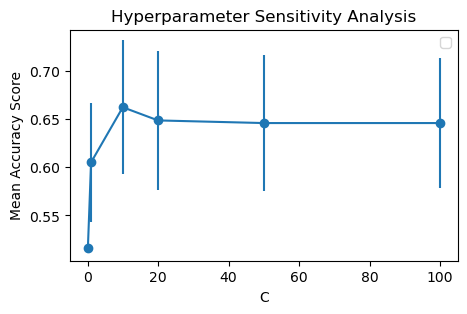

In [33]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

X_test_trans = vectorizer.transform(X_test)


def sensitivity_analysis(model, param_grid, X, y, scorer, cv=5):
    results = []
    for param, values in param_grid.items():
        for value in values:
            model.set_params(**{param: value})
            scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=None)
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            results.append((param, value, mean_score, std_score))
            print(
                f"Param: {param}, Value: {value}, Mean Accuracy Score: {mean_score:.4f}, Std: {std_score:.4f}"
            )
    return results


param_grid = {"C": [0.1, 1, 10, 20, 50, 100]}


def accuracy(estimator, X, y):
    y_pred = estimator.predict(X)
    return accuracy_score(y, y_pred)


sensitivity_results = sensitivity_analysis(
    classifier, param_grid, X_test_trans, y_test, accuracy, cv=5
)

sensitivity_df = pd.DataFrame(
    sensitivity_results, columns=["Parameter", "Value", "Mean Accuracy Score", "Std"]
)


for param in param_grid.keys():
    plt.figure(figsize=(5, 3))
    subset = sensitivity_df[sensitivity_df["Parameter"] == param]
    plt.errorbar(
        subset["Value"], subset["Mean Accuracy Score"], yerr=subset["Std"], fmt="-o"
    )  # label=param

    plt.xlabel(param)
    plt.ylabel("Mean Accuracy Score")
    plt.title("Hyperparameter Sensitivity Analysis")
    plt.legend()
    plt.show()